In [1]:
from SimuSamp.new_funcs.load.SpatDat import SpatDat
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
#
from libpysal import weights
from esda.moran import Moran_Local
#
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
#
import alphashape
#
from sklearn.cluster import DBSCAN
#
from shapely.geometry import Polygon, MultiPolygon

In [2]:
parent_filepath = "C:/Users/Michael/Desktop/block_data"
sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]
microns_per_pixel = 0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

In [3]:
spatdat = SpatDat(sampleid="13_G", parent_filepath=parent_filepath)

In [4]:
all_cells = spatdat.subset_cells("extended_partition")
im_cells = spatdat.subset_cells("IM")
tum_cells = spatdat.subset_cells("tumour")

In [5]:
tum_hull = spatdat.subset_annotation("tumour_hull")

In [6]:
import random
from shapely import Point
# Calculate areas with random points (faster than dilating annos)
def rand_points(annotation, n_points):
    
    min_x, min_y, max_x, max_y = annotation.bounds

    points = []
    while len(points) < n_points:
        x = random.uniform(min_x, max_x)
        y = random.uniform(min_y, max_y)
        point = Point(x, y)

        if annotation.contains(point):
            type(point)
            points.append(point)
    
    rand_df = gpd.GeoDataFrame({"geometry": points}, geometry="geometry")
    
    return rand_df

In [7]:
partition = spatdat.subset_annotation("extended_partition")
n_cd8 = len(all_cells)
n_cd8

cd8_den = n_cd8 / (partition.area * mm2_per_pixels2)

In [8]:
rand = rand_points(partition, n_cd8)

In [9]:
def get_tdist(gdf, tum_hull):
    gdf["tdist"] = gdf.geometry.distance(tum_hull)
    gdf["tdist_abs"] = gdf.geometry.distance(tum_hull.boundary)

    inside_mask = gdf["tdist"] == 0

    gdf.loc[inside_mask, "tdist"] = -gdf.loc[inside_mask, "tdist_abs"]

    gdf = gdf.drop("tdist_abs", axis=1)

    gdf = gdf.sort_values("tdist").reset_index(drop=True)

    gdf["tdist_microns"] = gdf["tdist"] * microns_per_pixel
    width = 50
    gdf["tdist_bin"] = [(x // width) * width for x in gdf["tdist_microns"]]

    return gdf

In [10]:
rand_dist = get_tdist(rand, tum_hull)

In [11]:
areas = rand_dist["tdist_bin"].value_counts() / cd8_den
rand_dist["area"] = rand_dist["tdist_bin"].map(areas)

In [12]:
rand_dist

,geometry,tdist,tdist_microns,tdist_bin,area
0,POINT (60719.384 45409.989),-15150.456093,-3441.426102,-3450.0,0.027178
1,POINT (61033.435 45232.826),-15136.470195,-3438.249205,-3450.0,0.027178
2,POINT (60655.359 45523.24),-15131.621100,-3437.147733,-3450.0,0.027178
3,POINT (60884.57 45093.276),-15071.568444,-3423.506772,-3450.0,0.027178
4,POINT (61130.013 45164.728),-15029.570550,-3413.966950,-3450.0,0.027178
...,...,...,...,...,...
53866,POINT (98122.663 43236.445),4398.766584,999.179830,950.0,2.976024
53867,POINT (97945.803 24812.163),4398.864089,999.201978,950.0,2.976024
53868,POINT (93333.533 61884.744),4399.316225,999.304681,950.0,2.976024
53869,POINT (82817.408 74555.153),4399.408458,999.325631,950.0,2.976024


In [17]:
cd8_dist = get_tdist(all_cells, tum_hull)

In [18]:
cd8_dist

,Analysis Region,CD8,geometry,index_right,layer,tdist,tdist_microns,tdist_bin
0,Partition Zone,1.0,POINT (60833.5 45414.5),5,extended_partition,-15124.934925,-3435.628968,-3450.0
1,Partition Zone,1.0,POINT (60920 45343.5),5,extended_partition,-15123.862544,-3435.385377,-3450.0
2,Partition Zone,1.0,POINT (60889 45403),5,extended_partition,-15098.029706,-3429.517448,-3450.0
3,Partition Zone,1.0,POINT (60784.5 45062.5),5,extended_partition,-14992.354668,-3405.513363,-3450.0
4,Partition Zone,1.0,POINT (60501 45384.5),5,extended_partition,-14937.458360,-3393.043666,-3400.0
...,...,...,...,...,...,...,...,...
53866,Partition Zone,1.0,POINT (84454.5 62003.5),5,extended_partition,4397.169374,998.817023,950.0
53867,Partition Zone,1.0,POINT (39144.5 27600.5),5,extended_partition,4397.280125,998.842180,950.0
53868,Partition Zone,1.0,POINT (56225 83180.5),5,extended_partition,4398.735074,999.172672,950.0
53869,Partition Zone,1.0,POINT (33993 69009.5),5,extended_partition,4400.838130,999.650381,950.0


In [50]:
# Merge areas and cell counts
cd8_counts = cd8_dist["tdist_bin"].value_counts().reset_index()
cd8_counts = cd8_counts.merge(rand_dist[["tdist_bin", "area"]], on="tdist_bin", how="left")
cd8_counts = cd8_counts.drop_duplicates().reset_index(drop=True)

In [51]:
cd8_counts

,tdist_bin,count,area
0,50.0,3082,5.710840
1,100.0,2838,5.282782
2,150.0,2756,4.813956
3,200.0,2527,4.294171
4,-0.0,2450,6.869315
...,...,...,...
84,-3250.0,39,0.203837
85,-3350.0,27,0.135892
86,-3300.0,24,0.186851
87,-3400.0,7,0.044165


In [55]:
cd8_counts["den"] = (cd8_counts["count"]) / (cd8_counts["area"])

In [57]:
cd8_counts["prob"] = (cd8_counts["count"] / cd8_counts["count"].sum()) / (cd8_counts["area"] / cd8_counts["area"].sum())

In [62]:
cd8_counts = cd8_counts.sort_values("tdist_bin")

Text(0, 0.5, 'Probability')

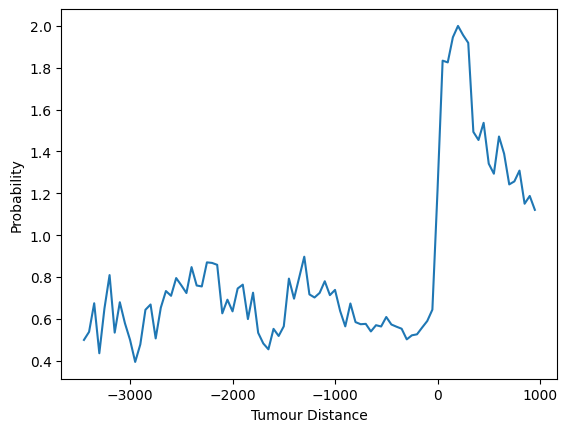

In [64]:
plt.plot(cd8_counts["tdist_bin"], cd8_counts["prob"])
plt.xlabel("Tumour Distance")
plt.ylabel("Probability")